In [150]:
import gym
import gym_battleship

from Battleship_agent import * 

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque, namedtuple
from tqdm import tqdm

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('AdversarialBattleship-v0')
REPLAY_SIZE = 1000000
D_BATCH_SIZE = 5
A_BATCH_SIZE = 100


In [152]:
step_format = namedtuple('step', ['state', 'reward', 'done', 'info'])
a_agent = env.attacker_action_space.sample
d_agent = env.defender_action_space.sample

A_ACTION_SPACE = env.attacker_action_space.n
D_ACTION_SPACE = env.defender_action_space[0].n * env.defender_action_space[1].n
D_STATE_SPACE = 100 + 10



In [153]:
#Masking defender's action
def invalid_action(pos, orien, length, s):
    j = pos % 10 #rownum
    i = int(pos / 10) #colnum
    if orien == 1 and 10 - j < length:
        return True
    elif orien == 0 and 10 - i < length:
        return True
    else:
        for p in range(0, 10):
            for q in range(0, 10):
                if orien == 0:
                    if (p >= i and p < (i + length)) and q == j:
                        if s[p][q] != 0:
                            return True
                elif orien == 1:
                    if p == i and (q < (j + length) and q >= j):
                        if s[p][q] != 0:
                            return True
    return False


In [172]:
class DefenderDQNnet(nn.Module):

    def __init__(self):
        super(DefenderDQNnet, self).__init__()
        self.linear1 = nn.Linear(D_STATE_SPACE, 110)#, padding="same")
        # self.linear1 = nn.Linear(OBSERVATION_SPACE, 10)
        # self.linear2 = nn.Linear(10, 128)
        self.linear2 = nn.Linear(110, 200)
        self.linear3 = nn.Linear(200, D_ACTION_SPACE)
    
    def forward(self, state):

        o1 = F.relu(self.linear1(state))
        o2 = F.relu(self.linear2(o1))
        oo = self.linear3(o2)
        return oo

class DefenderDQN():
    def __init__(self, lr=.001, epsilon=.1, gamma=.99,test=False):
        self.test = test

        self.lr = lr
        self.epsilon = epsilon 
        self.gamma = gamma
        
        self.target_net = DefenderDQNnet().to(device)
        self.optim = torch.optim.Adam(self.target_net.parameters(), lr=self.lr)
        
        self.replay_buffer = deque()
        self.loss_function = nn.MSELoss()
             
   #The action mask is a 1x200 array, which roughly represents 2 10x10 matrices here.
    def choose_action_egreedy(self, state):
        # print(state[0])
        s = np.concatenate((state[0].transpose().reshape(100), state[1]), axis=None)
        ob = torch.unsqueeze(torch.FloatTensor(s).to(device), 0)
        
        mask = np.concatenate((np.copy(state[0]).reshape(100),np.copy(state[0]).reshape(100)), axis=None)
        
        length = 10
        for i in range(len(state[1]) - 1, -1, -1):
            if state[1][i] != 0:
                length = i
                break
        for i in range(0, 100):
            if invalid_action(i, 0, length, state[0]):
                mask[i] = 1
        for i in range(100, len(mask)):
            if invalid_action(i-100, 1, length, state[0]):
                mask[i] = 1
        #Print mask in matrix
        # print(mask[0:100].reshape((10,10)))
        # print(mask[100:200].reshape((10,10)))

        if np.random.uniform() > self.epsilon:
            action_value = self.target_net(ob.to(device))
            ac = action_value.detach().cpu().numpy()
            action_value = np.argmax(np.ma.masked_array(ac, mask))

        else:
            # print(np.argwhere(mask == 0).reshape(-1))
            action_value = np.random.choice(np.argwhere(mask == 0).reshape(-1))

        return int(action_value)

    def save_transition(self, s, a, r, ns, done):
        one_hot_action = np.zeros(D_ACTION_SPACE)
        one_hot_action[a] = 1
        s = np.concatenate((s[0], s[1]), axis=None)
        ns = np.concatenate((ns[0], ns[1]), axis=None)
        self.replay_buffer.append((s, one_hot_action, r, ns, done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()
        if len(self.replay_buffer) > D_BATCH_SIZE:
            self.learn()

    def learn(self):
        
        minibatch = random.sample(self.replay_buffer, D_BATCH_SIZE)
        state_batch =  torch.FloatTensor([d[0] for d in minibatch]).to(device)

        action_batch = torch.LongTensor([d[1] for d in minibatch]).to(device)

        reward_batch = torch.FloatTensor([d[2] for d in minibatch]).to(device)

        nstate_batch = torch.FloatTensor([d[3] for d in minibatch]).to(device)
        done_batch = torch.FloatTensor([d[4] for d in minibatch]).to(device)
        done_batch = done_batch.unsqueeze(1)
        reward_batch = reward_batch.unsqueeze(1)
        action_index = action_batch.argmax(dim=1).unsqueeze(1)

        q = self.target_net(state_batch).gather(1, action_index)#action_batch.unsqueeze(1))

        naction_batch = torch.unsqueeze(torch.max(self.target_net(nstate_batch), 1)[1], 1)
        next_q = self.target_net(nstate_batch).gather(1, naction_batch)

        delta = reward_batch + self.gamma * next_q * (1- done_batch)

        loss = self.loss_function(q, delta)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()


In [155]:
def run( d_agent,a_agent, episode=100, a_test=False, d_test=False, printing=False):
    d_agent.test = d_test
    a_agent.test = a_test
    
    avg_reward = []
    steps = []
    for e in tqdm( range(episode) ):
        r = 0
        state = env.defender_reset()
        while True:

            action = d_agent.choose_action_egreedy(state)
            # print(action)
            temp = env.defender_step(action % 100 % 10 * 10 + int(action % 100 / 10), int(action / 100))
            if temp:
                nstate, reward, done, _ = temp
            
                state = nstate
                r += reward

            #When all ships set, we give turn to attacker
            else:
                break

        #Start the attacker
        attacker_step = step_format(*env.attacker_initialization(), False, {})
        a_state = np.array([attacker_step[0], attacker_step[1]])
        
        if e >= episode - 1 and printing:
            env.render_board_generated()
        
        step = 0
        a_agent.action_mask = np.zeros(A_ACTION_SPACE)
        p_reward = 0
        while True:
            step += 1
            a_action = a_agent.choose_action(a_state)
            a_nstate, a_reward, a_done, _= env.attacker_step(a_action)
            #Modify the reward
            if p_reward > 0 and reward > 0:
                reward += p_reward
            if printing and e >= episode - 1:
                env.render()
                print(action)
            
            #Train the attacker if the attacker agent is set to learn in the adversary
            if not a_test:
                a_agent.save_transition(a_state, a_action, a_reward, a_nstate, a_done)
                a_state = a_nstate
            if a_done:
                break  

        #Attacker completes the game, defender resolves its reward
        nstate, reward, done, _ = env.defender_step(action % 100 % 10 * 10 + int(action % 100 / 10), int(action / 100))
        reward = step - 70
        #Train the defender if the defender agent is set to learn in the adversary
        if not d_test:
            d_agent.save_transition(state, action, reward, nstate, done)
        avg_reward.append(reward)
        steps.append(step)
    return avg_reward, steps


  0%|          | 5/1000 [00:05<19:53,  1.20s/it]/tmp/ipykernel_13409/1272018136.py:85: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  action_batch = torch.LongTensor([d[1] for d in minibatch]).to(device)
100%|██████████| 1000/1000 [22:51<00:00,  1.37s/it]


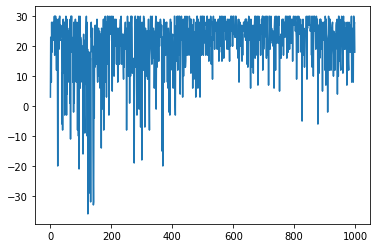

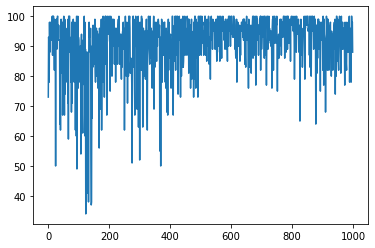

In [156]:

a2 = AttackerDQN(env, adversarial=True, epsilon=.2)
#Load the pre-trained network from Battleship_agent.py
a2.target_net.load_state_dict(torch.load('./aDQN'))
a1 = DefenderDQN(epsilon=.5)
#Start generative adversary game. Here a_test = True means the attacker is not going to learn anything for this run. So as d_test for defender agent
r1, s1 = run(a1, a2, episode=1000, a_test=False, d_test=False)
#Show the reward of defender. This gives a direct idea on how the two agent fights aganist each other
plt.plot(r1)
plt.show()
plt.plot(s1)
plt.show()
#Save the network weight
torch.save(a2.target_net.state_dict(), "./attacker")
torch.save(a1.target_net.state_dict(), "./defender")

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

68.09


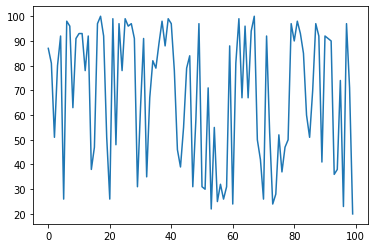

  3%|▎         | 3/100 [00:00<00:03, 25.89it/s]/tmp/ipykernel_13409/1272018136.py:85: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  action_batch = torch.LongTensor([d[1] for d in minibatch]).to(device)
100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


93.49


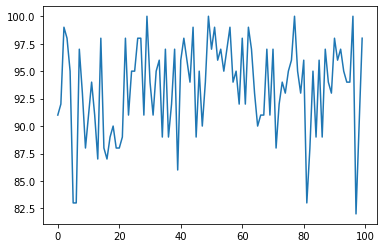

In [159]:

a2 = AttackerDQN(env, adversarial=True, epsilon=.2)
a2.target_net.load_state_dict(torch.load('./attacker'))
a1 = DefenderDQN(epsilon=.2)
a1.target_net.load_state_dict(torch.load('./defender'))
_, r1 = run(a1, a2, episode=100, a_test=False, d_test=True, printing=False)
print(sum(r1) / len(r1))
plt.plot(r1)
plt.show()


a2 = AttackerDQN(env, adversarial=True, epsilon=.2)
a2.target_net.load_state_dict(torch.load('./attacker'))
a1 = DefenderDQN(epsilon=.2)
a1.target_net.load_state_dict(torch.load('./defender'))
_, r1 = run(a1, a2, episode=100, a_test=True, d_test=False, printing=False)
print(sum(r1) / len(r1))
plt.plot(r1)
plt.show()


In [171]:
#Print a sample game
a2 = AttackerDQN(env, adversarial=True, epsilon=.2)
a2.target_net.load_state_dict(torch.load('./attacker'))
a1 = DefenderDQN(epsilon=.2)
a1.target_net.load_state_dict(torch.load('./defender'))
_, r1 = run(a1, a2, episode=1, a_test=False, d_test=True, printing=True)
print(r1)

  0%|          | 0/1 [00:00<?, ?it/s]

,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
3,⬛,⬛,⬛,⬜,⬜,⬜,⬜,⬜,⬜,⬜
4,⬜,⬜,⬜,⬛,⬛,⬛,⬛,⬜,⬜,⬜
5,⬜,⬜,⬛,⬛,⬛,⬜,⬜,⬜,⬜,⬜
6,⬜,⬜,⬜,⬜,⬜,⬜,⬛,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬛,⬛,⬛,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬛,⬜,⬜,⬜
9,⬜,⬜,⬜,⬜,⬜,⬜,⬛,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬛,⬜,⬜,⬜


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⬜,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⬜
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⬜,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,⬜,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⬜,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,⬜,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,⬜,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⬜,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,⬜,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,⬜,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⬜,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⬜,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⬜,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⬜,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⬜
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⬜,⚫,⬜,⚫,⬜,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⬜,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⬜,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⬜,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⬜,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⬜
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⬜,⬜,⬜
9,⬜,⬜,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⬜
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⬜,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⬜,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⬜


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⬜
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⬜,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⬜,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⬜,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⬜,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,⬜,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,⬜,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⬜,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⬜,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⬜,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⬜,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⚫,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⬜,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⚫,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⚫,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⬜,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,⬜,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,⬜,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⬜,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⬜,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⬜,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⬜,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⬜,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⬜,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⬜,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⬜,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,⬜,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,⬜,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⬜,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,⬜,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⬜,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⬜,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⬜,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⬜,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⬜,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⬜,⚫,⬜,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⬜,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⬜,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⬜
9,⚫,⚫,⚫,⚫,⬜,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⬜,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⬜
9,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,⬜,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⚫,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⬜
9,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


164


,A,B,C,D,E,F,G,H,I,J
1,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⬜,⚫,⬜
2,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫,⚫
3,❌,❌,❌,⚫,⚫,⚫,⚫,⚫,⚫,⚫
4,⚫,⚫,⚫,❌,❌,❌,❌,⚫,⚫,⚫
5,⚫,⚫,❌,❌,❌,⚫,⚫,⬜,⚫,⚫
6,⚫,⚫,⚫,⚫,⚫,⬜,❌,⚫,⚫,⬜
7,⚫,⚫,⚫,⚫,❌,❌,❌,⚫,⚫,⚫
8,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⬜
9,⚫,⚫,⚫,⚫,⚫,⚫,❌,⚫,⚫,⚫
10,⬜,⚫,⚫,⚫,⚫,⚫,❌,⚫,⬜,⚫


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

164
[92]
